# Исследование объявлений о продаже квартир

Основная задача проекта - получив очищенную и репрезентативную выборку после применения механизмов предобработки, провести анализ зависимости основных велечин, важных для понимания рынка недвижимости Санкт-Петрербурга и его окресностей. Важными зависимостями будут являться взаимосвязи стоимости квартир с различными метриками, например, количеством комнат, расстоянием от центра города, датой и днем размещения объявления. Необходимо в итоге работы ответить на вопрос "Что влияет на ыормирование цены, из чего она складыватся и как меняется?". Для этого будет проведены работы по предобработке данных, поиску и исключению выбросов в данных и непосредственному анализу. 

In [39]:
import pandas as pd
import string
import seaborn
import matplotlib.pyplot as plt

from pathlib import Path

In [40]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

### Изучим данные

#### Общая информация

Ниже, небольшая модернизация с помощью функции, которая учитывает различные варианты источников и путей. Конечно, задача здесь простая и не требует такого комплексного подхода, но при изменении условий и сред исполнения, такой подход позволит избежать дополнительных адаптаций кода. 
    Функция перебирает словарь с переменными и их путями, ищет первый существующий файл для каждой переменной и читает его.
    Возвращает словарь с данными из найденных файлов. Если указан параметр assign_to, присваивает каждый DataFrame
    соответствующей переменной в этом словаре.
    
    :param data_sources: словарь с названиями переменных и списками их путей
    :param assign_to: словарь, в который будут присвоены DataFrame'ы
    :return: словарь с данными для каждой переменной

In [41]:
data = pd.read_csv("real_estate_data.csv")

In [42]:
def find_and_select_data_files(data_sources, assign_to=None):

    data_frames = {}

    for variable, paths in data_sources.items():
        for file_path in paths:
            file = Path(file_path)
            if file.exists() and file.is_file():
                try:
                    if file.suffix == '.csv':
                        df = pd.read_csv(file, sep="\t")
                    elif file.suffix in ['.xls', '.xlsx']:
                        df = pd.read_excel(file, sep="\t")
                    else:
                        print(f"Формат файла '{file.suffix}' не поддерживается.")
                        continue

                    data_frames[variable] = df
                    print(f"Для переменной '{variable}' прочитан файл: {file}")

                    if assign_to is not None and variable in assign_to:
                        globals()[assign_to[variable]] = df

                except Exception as e:
                    print(f"Ошибка при чтении файла '{file}': {e}")
                break
        else:
            print(f"Файл данных для переменной '{variable}' не найден.")
    
    return data_frames

In [43]:
data_sources = {
    "data": ["/datasets/real_estate_data.csv", "real_estate_data.csv"]
}

assignments = {
    "data": "data"
}


dfs = find_and_select_data_files(data_sources, assign_to=assignments)

Для переменной 'data' прочитан файл: real_estate_data.csv


In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Итак, данные содержатся в 23699 строках в разрезе 22х столбцов. Есть несколько очевидных проблем в данных, которые стоит изучить и поправить в рамках дальнейшей предобработки данных (п.2): 
* Названия столбцов "parks_around3000", "ponds_around3000" и "cityCenters_nearest" однозначно определяют содержащиеся в них данные, но их названия лучше привести к единому стилю, убрав цифры, убрав заглавные буквы, добавив нижнее подчеркивание в качестве разделителя. 
* Далеко не все столбцы имеют полный набор ненулевых значений из всей выборки. Нужно внимательно проверить столбцы с количеством ненулевых значений меньше 23699 заполнить пропуски и сделать очистку.
* В столбце "first_day_exposition" подстоит работа с типом данных "Datatime" для полноценной работы с датой и временем. 
* Использование названия "floor" для столбца, содержащего значение текущего этажа, может привести к ошибке, т.к. в Pyton используется функция "floor". Переименуем этот столбец в "current_floor"


Посмотрим на сам датафрейм

In [45]:
data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,False,False,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,False,False,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,False,False,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,False,False,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,False,False,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,False,False,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,False,False,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


Гипотезы о целочисленности значений в "floors_total", "balcony", "parks_around3000", "ponds_around3000" и "days_exposition" становится правдоподобной - после точек видим незначащие нули. 

Теперь взглянем на гистограммы по всем значениям:

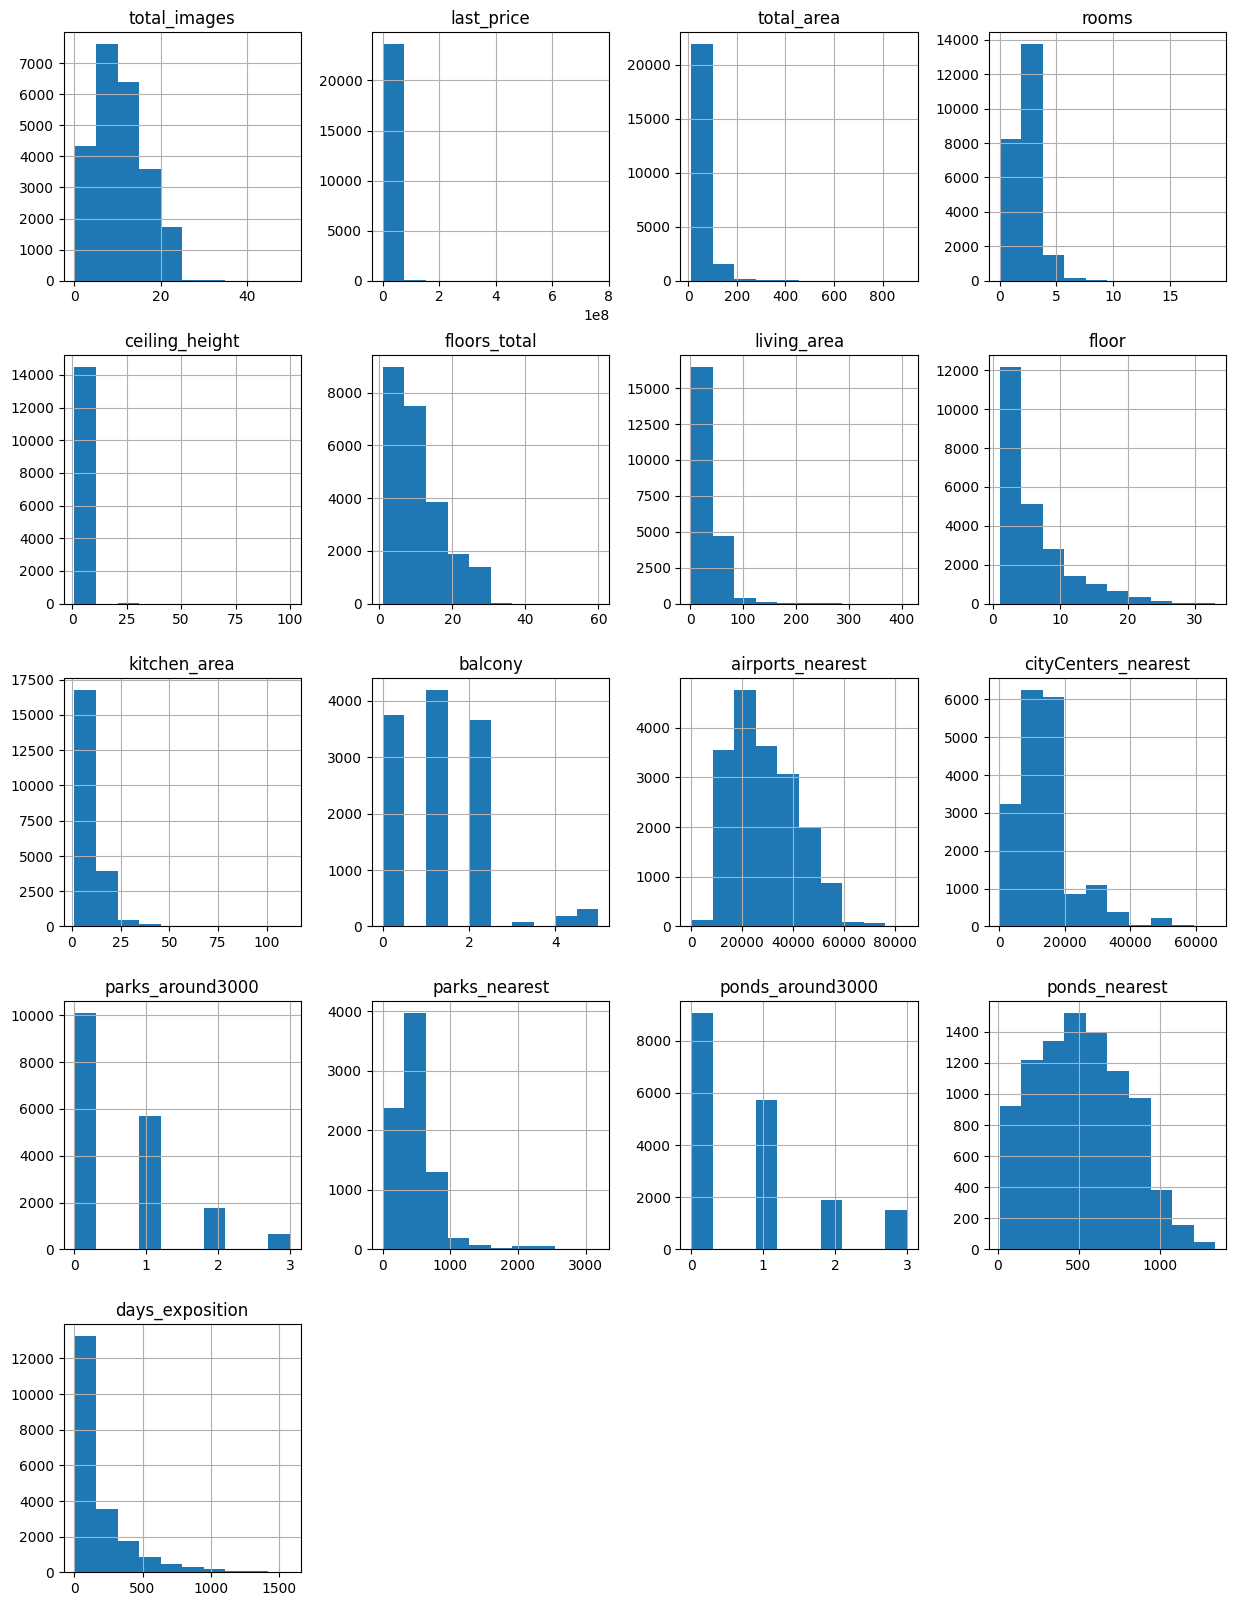

In [46]:
data.hist(figsize=(15, 20))
plt.show()

* Определенно что-то не так с отображением данных из "last_price", "total_area" и "ceiling_height"- гистограммы не дает никакого рапределения, а только одинокие пики. Вероятно это происходит из-за диапазона значений. Стоит посмотреть на эти показатели в других диапазонах детальнее.  
* Подозрительный выброс для квартир с пятью балконами ("balcony").
* Есть выброс в значениях с расстоянием до центра ("cityCenters_nearest") в районе 50км. Можно объяснить активной застройкой области города. Стоит изучить подробнее эту гипотезу.
* Явный пик в области менее 250 дней для "days_exposition" вполне оправдан и, верочтно, стоит рассматривать именно этот диапазон данных для анализа, но то что данные здесь распределяются вплоть до 1500 дней подозрительно. 


### Предобработка данных

#### Корректировка названий столбцов

In [47]:
data = data.rename(
    columns=
    {
        'parks_around3000': 'parks_around',
        'ponds_around3000': 'ponds_around',
        'cityCenters_nearest': 'city_centers_nearest',
        'floor': 'current_floor'
    }
) 

data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area',
       'current_floor', 'is_apartment', 'studio', 'open_plan', 'kitchen_area',
       'balcony', 'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around', 'parks_nearest', 'ponds_around', 'ponds_nearest',
       'days_exposition'],
      dtype='object')

#### Обработка пропусков в данных
Посмотрим в каких столбцах есть пропуски и определим методы их обработки 

In [48]:
data.isna().mean().round(4).to_frame().sort_values(by=0).style.format('{:.2%}').background_gradient('coolwarm')

,0
total_images,0.00%
open_plan,0.00%
current_floor,0.00%
rooms,0.00%
studio,0.00%
total_area,0.00%
last_price,0.00%
first_day_exposition,0.00%
locality_name,0.21%
floors_total,0.36%


Обработаем имеющися пропуски следующими способами, учитывая, что в выборке 23699 строк:
* ceiling_height           9195 - заполним медианами по локации 
* floors_total               86 - оставим как как есть. Можно заполнить значением этажа квартиры но в этом случае искажение данных может быть сильным в отдельных случаях, например, дом с 12ю этажами станет одноэтажным таунхаусом, что сильно выбьет его из показателей. К тому же пропусков не так много чтобы такое количество пустых значений отразилось на результате. 
* living_area              1903 - заполним значениями total_area за вычетом kitchen_area
* is_apartment            20924 - удалим столбец - для анализа эти данные использоваться не будут. 
* kitchen_area             2278 - заполним значениями total_area за вычетом living_area 
* balcony                 11519 - заполняем False считая что балкона нет - такой подход не исказит результат, так как не будет введено дополнительного фактора для поиска корреляций
* locality_name              49 - удалим строки с пустыми значениями. Восстановить их не получится по другим данным, а любые догадки исказят данные
* airports_nearest         5542 - заполним медианным значением по группам из locality_name 
* city_centers_nearest     5519 - заполним медианным значением по группам из locality_name кроме Санкт-Петрбурга
* parks_around             5518 - возьмем данные из столбца parks_nearest при условии значения <= 3000м. Для пропусков установим значение 1, т.к. в обозначенном радиусе будет хотя бы один парк. В ином случае установим значение 0. Остальные пропуски оставим без изменений 
* parks_nearest           15620 - возьмем данные из столбца parks_around при условии значения >= 1. Для значений с пропусками установим значение 3000, т.к. если значение ponds_around не нулевой, значит в радиусе 3000 есть хотя бы один парк. Остальные пропуски оставим без изменений.
* ponds_around             5518 - возьмем данные из столбца parks_nearest при условии значения <= 3000м. Для значений с пропусками установим значение 1, т.к. в обозначенном радиусе будет хотя бы один водоем. Остальные пропуски оставим без изменений 
* ponds_nearest           14589 - возьмем данные из столбца ponds_around при условии значения >= 1. Для значений с пропусками установим значение 3000, т.к. если значение ponds_around не нулевой, значит в радиусе 3000 есть хотя бы один водоем. Остальные пропуски оставим без изменений.
* days_exposition          3181 - вероятно(требует проверки у поставщика данных) значения пустые из-за того, что объявление не было снято с публикации на момент выгрузки. Приняв такую гепотезу, можно вычислять пропущенные значения вычислением разницы в днях между днем публикации "first_day_exposition" и максимальным значением даты снятия с публикации по всей выборке и при этом внести дополнительную информацию о снятии объявления в отдельном булевом столбце. Однако, в облаке Яндекс перевести значения datatime в int невозможно в рамках такой задачи, поэтому оставим эти пропуски и будем иметь ввиду данную гипотезу при анализе. 


##### Заполним поропуски в столбце "ceiling_height" содержащим высоту потолков. Здесь всего 13% пропусков и на общую картину сильного влияния не окажет заполнение медианным значением. Для получения более реальной картины испольуем не общую медиану значений столбца, а медианы по локациям. 
\* В реальной задаче было бы хорошо получить более детальную информацию о локации, например, улицу - ее достать не составит проблем и такая информация чаще всего есть в подобных выборках. Идеально бы подошла инормация о типе или годах затройки. 



Оставшиеся пропуски связаны с недостатком значащих данных о высоте потолков в отдельно взятых локациях (вычислить медиану из пропусков не получится). Оставим пропуски в таком виде, чтобы не увеличивать влияние на достоверность выборки. Сокращение доли пропусков в этом столбце до менее чем 1го процента - неплохой результат. 

In [49]:
data['ceiling_height'] = data.groupby('locality_name')['ceiling_height'].transform('median')

##### Заполним значениями total_area за вычетом kitchen_area

Сначала вычисчлим среднее значение площади подсобных помещение по всех выборке, где пропуски есть. 

In [50]:
closet_area_mean = (data['total_area'] - data['living_area'] - data['kitchen_area']).mean()

Учтем это значение для заполнения пропусков:

In [51]:
data['living_area'] = data['living_area'].fillna(data['total_area'] - data['kitchen_area'] - closet_area_mean)
print('После обработки осталось', data['living_area'].isna().sum(), 'пропусков')

После обработки осталось 1464 пропусков


Выбранный способ позволил заолнить 69% процентов пропусков в столбце. Оставшиеся пропуски связаны с отсутствием данных об общей площади или площади кухни в отдельно взятых локациях. Оставим пропуски в таком виде, чтобы не увеличивать влияние на достоверность выборки.

In [174]:
living_coeff = (data['total_area']/data['living_area']).median()
living_coeff

1.7333333333333334

In [53]:
data.loc[data['living_area'].isna(), 'living_area'] = data['total_area'] * living_coeff

##### Удалим столбец "is_apartment" - для анализа эти данные использоваться не будут

In [54]:
data.pop('is_apartment')

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10         NaN
11       False
12         NaN
13         NaN
14         NaN
15         NaN
16         NaN
17         NaN
18         NaN
19         NaN
20         NaN
21         NaN
22         NaN
23         NaN
24         NaN
25       False
26         NaN
27         NaN
28         NaN
29       False
30         NaN
31         NaN
32         NaN
33         NaN
34         NaN
35         NaN
36       False
37         NaN
38         NaN
39         NaN
40         NaN
41       False
42       False
43         NaN
44         NaN
45         NaN
46         NaN
47         NaN
48         NaN
49         NaN
50       False
51         NaN
52         NaN
53         NaN
54         NaN
55         NaN
56       False
57         NaN
58         NaN
59         NaN
60         NaN
61         NaN
62         NaN
63         NaN
64         NaN
65         NaN
66       F

##### Заполним "kitchen_area" значениями "total_area" за вычетом "living_area"

In [55]:
data['kitchen_area'] = data['kitchen_area'].fillna(data['total_area'] - data['living_area'])
print('После обработки осталось', data['kitchen_area'].isna().sum(), 'пропусков')
data.isna().sum()

После обработки осталось 0 пропусков


total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height            170
floors_total               86
living_area                 0
current_floor               0
studio                      0
open_plan                   0
kitchen_area                0
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around             5518
parks_nearest           15620
ponds_around             5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Выбранный способ позволил заолнить 73% процентов пропусков в столбце. Оставшиеся пропуски связаны с тем же отсутствием данных по аналогии с п.2.2.2

#####  - заполняем пропуски в столбце "balcony" нулями, считая что балкона нет - такой подход не исказит результат, так как не будет введено дополнительного фактора для поиска корреляций

In [56]:
data['balcony'] = data['balcony'].fillna(0)
print('После обработки осталось', data['balcony'].isna().sum(), 'пропусков')    
data.isna().sum()

После обработки осталось 0 пропусков


total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height            170
floors_total               86
living_area                 0
current_floor               0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around             5518
parks_nearest           15620
ponds_around             5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

#####  Удалим в "locality_name" строки с пустыми значениями

In [57]:
data = data.dropna(subset=['locality_name'])
print('После обработки осталось', data['locality_name'].isna().sum(), 'пропусков')  
data.isna().sum()

После обработки осталось 0 пропусков


total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height            121
floors_total               85
living_area                 0
current_floor               0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5534
city_centers_nearest     5511
parks_around             5510
parks_nearest           15586
ponds_around             5510
ponds_nearest           14565
days_exposition          3180
dtype: int64

#####  заполним медианным значением по группам из "locality_name" пропуски в "airports_nearest"

In [58]:
for location in data['locality_name'].unique():
    data.loc[(data['locality_name'] == location) & (data['airports_nearest'].isna()), 'airports_nearest'] = \
    data.loc[(data['locality_name'] == location) & (~data['airports_nearest'].isna()), 'airports_nearest'].median()
   
       
print('После обработки осталось', data['airports_nearest'].isna().sum(), 'пропусков, рпаспределенных по локациям следующим образом:')        
print(data[data['airports_nearest'].isna()]['locality_name'].value_counts()) 

После обработки осталось 5386 пропусков, рпаспределенных по локациям следующим образом:
locality_name
посёлок Мурино                                             522
Всеволожск                                                 398
Гатчина                                                    307
деревня Кудрово                                            299
Выборг                                                     237
Кудрово                                                    173
деревня Новое Девяткино                                    144
Сертолово                                                  142
Кириши                                                     125
Сланцы                                                     112
Волхов                                                     111
Тосно                                                      104
Кингисепп                                                  104
Никольское                                                  93
Коммунар        

Выбранный способ позволил заолнить 95% процентов пропусков в столбце. Оставшиеся пропуски связаны, вероятнее всего, с тем, что аэропортов в этих локациях в принципе нет, поэтому заполним оставшиеся пропуски нулями. 

In [59]:
data['airports_nearest'] = data['airports_nearest'].fillna(0)
print('После обработки осталось', data['airports_nearest'].isna().sum(), 'пропусков')  


После обработки осталось 0 пропусков


#####   Заполним пропуски "city_centers_nearest" медианным значением по группам из "locality_name"

In [60]:
for location in data['locality_name'].unique():
    data.loc[(data['locality_name'] == location) &
             (data['locality_name'] != 'Санкт-Петербург') &
             (data['city_centers_nearest'].isna()), 'city_centers_nearest'] = \
    data.loc[(data['locality_name'] == location) &
             (data['locality_name'] != 'Санкт-Петербург') &
             (~data['city_centers_nearest'].isna()), 'city_centers_nearest'].median()
   
       
print('После обработки осталось', data['city_centers_nearest'].isna().sum(), 'пропусков, рпаспределенных по локациям следующим образом:')        
print(data[data['city_centers_nearest'].isna()]['locality_name'].value_counts()) 


После обработки осталось 5447 пропусков, рпаспределенных по локациям следующим образом:
locality_name
посёлок Мурино                                             522
Всеволожск                                                 398
Гатчина                                                    307
деревня Кудрово                                            299
Выборг                                                     237
Кудрово                                                    173
деревня Новое Девяткино                                    144
Сертолово                                                  142
Кириши                                                     125
Сланцы                                                     112
Волхов                                                     111
Кингисепп                                                  104
Тосно                                                      104
Никольское                                                  93
Коммунар        

Выбранный способ позволил заолнить 95% процентов пропусков в столбце. Оставшиеся пропуски связаны повторяются с промежуточными в п.2.2.8. Помимо отсутствия аэропортов, эти локации содержат данные о недвижимости в небольших поселениях, где не применимо понятия центра города. Также из этой обработки был исключен мегополис Санкт-Петербург, чтобы данные по не му не повлияли на общий результат - Заполнять огромный город медианой пространственного параметра неверно. 

#####  Для заполнения пропусков в  parks_around возьмем данные из столбца parks_nearest. Так же поступим для пары "ponds_around" "ponds_nearest"

In [61]:
data.loc[data['parks_nearest'] <= 3000, 'parks_around'] = data.loc[data['parks_nearest'] <= 3000, 'parks_around'].fillna(1) 
data.loc[data['parks_nearest'] > 3000, 'parks_around'] = data.loc[data['parks_nearest'] > 3000, 'parks_around'].fillna(0)
print('После обработки осталось', data['parks_around'].isna().sum(), 'после заполнения пропусков')

После обработки осталось 5510 после заполнения пропусков


Картина с пропусками не изменилась

In [62]:
data.loc[data['parks_around'].isna(), 'parks_nearest'].sum()

0.0

Оказывается, что в строка с пропусками "parks_around" также пропущены и значения "parks_nearest". Такая же ситуация и с водоемами:

In [63]:
data.loc[data['ponds_around'].isna(), 'ponds_nearest'].sum()

0.0

Остаавим все пропуски в водоемах и парках без изменений - так мы сохраним реалистичность выборки. 

#####  итоговый результат после обработки пропусков:




In [64]:
print(data.isna().sum())
print('Всего в выборке', data.isna().sum().sum(), 'пропусков')

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height            121
floors_total               85
living_area                 0
current_floor               0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest            0
city_centers_nearest     5447
parks_around             5510
parks_nearest           15586
ponds_around             5510
ponds_nearest           14565
days_exposition          3180
dtype: int64
Всего в выборке 50004 пропусков


Удалось сократить количество пропусков в выборке на 71% 

#### Скорректируем тип данных в "'first_day_exposition"

In [65]:
data['first_day_exposition'].head()

0    2019-03-07T00:00:00
1    2018-12-04T00:00:00
2    2015-08-20T00:00:00
3    2015-07-24T00:00:00
4    2018-06-19T00:00:00
Name: first_day_exposition, dtype: object

In [66]:
data['first_day_exposition'] = pd.to_datetime(
    data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S'
)
data['first_day_exposition'].head() 

0   2019-03-07
1   2018-12-04
2   2015-08-20
3   2015-07-24
4   2018-06-19
Name: first_day_exposition, dtype: datetime64[ns]

In [67]:
print(data['locality_name'].dtypes) 

object


In [68]:
data['locality_name'] = data['locality_name'].astype('str')

#### Обработка дубликатов

In [69]:
len(data['locality_name'].unique())

364

In [70]:
data['locality_name'] = data['locality_name'].str.lower()

display(len(data['locality_name'].unique()))


364

In [71]:

to_replace = {'ё':'е', \
              'поселок городского типа':'поселок', \
              'городской поселок':'поселок'
             }
data['locality_name'] = data['locality_name'].replace(to_replace, regex=True)

#### Поиск аномальных значений

##### Высота потолков

In [72]:
data['ceiling_height'].describe()


count    23529.000000
mean         2.673821
std          0.327757
min          2.450000
25%          2.700000
50%          2.700000
75%          2.700000
max         27.000000
Name: ceiling_height, dtype: float64

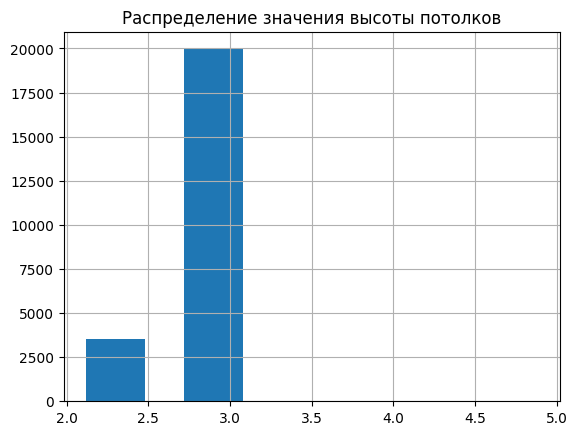

In [73]:
fig, ax = plt.subplots()

data['ceiling_height'].hist(range = (2, 5), bins=5, rwidth = 0.6)

ax.set_title('Распределение значения высоты потолков')

plt.show()

<Axes: >

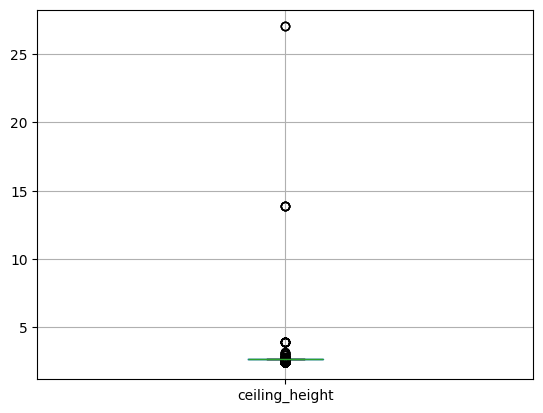

In [74]:
data.boxplot(column='ceiling_height')


При изучении столбца "ceiling_height" обнаруживаем явные выбросы как в сторону минимальных(1 метр) так и в сторону максимальных (100 метров) значений. Это явные ошибки в заполнении. Таких данных немного - изучим их подробнее

In [75]:
data.query('ceiling_height > 40')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,current_floor,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around,parks_nearest,ponds_around,ponds_nearest,days_exposition


In [76]:
data.query('ceiling_height <= 1')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,current_floor,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around,parks_nearest,ponds_around,ponds_nearest,days_exposition


Таких записей всего две и, если опираться на стоимость то, можно предположить, что ошибка при заполнении произошла при установке запятой - в первом случае завысив реальную высоту в десять раз, а во втором набоборот ее занизив. Корректировать эти значения не будем, чтобы не вностить ошибок при анализе. Создадим отдельный датафрейм без этих значений и, в анализе с участием высоты потолков будем обращаться к нему. 

In [77]:
data_ceiling_filter = data.query('100>ceiling_height>1')

<Axes: >

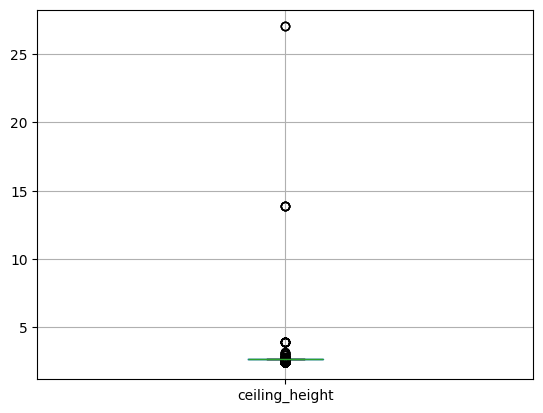

In [78]:
data_ceiling_filter.boxplot(column='ceiling_height')


Так уже лучше. Выбросы из здравого смысла все равно есть - изучим их со стороны минимума. Минимальная высота потолков России по всем нормам - это 2,4 метра. Все что ниже это могут быть подсобные помещения, по-ошибке ставшие панацеей для потолков жилого помещения. Как бы там ни было, в финальный отфильтрованный датафрейм помещать их не будем. 

In [79]:
data_ceiling_filter = data_ceiling_filter.query('ceiling_height>2.4')

Максимальная же высота потолков, например, элитного жилья со сдвоенными этажами не может быть выше 13 метров. В нашей выборке такие выбросы есть.  Таких данных немного - изучим их подробнее

In [80]:
data_ceiling_filter.query('ceiling_height > 13')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,current_floor,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around,parks_nearest,ponds_around,ponds_nearest,days_exposition
313,1,2450000.0,49.0,2016-03-09,3,13.85,5.0,34.0,2,False,False,5.5,1.0,поселок новый свет,0.0,NaN,NaN,NaN,NaN,NaN,189.0
839,14,1900000.0,35.0,2017-04-14,0,13.85,5.0,15.0,3,False,True,20.0,1.0,поселок новый свет,0.0,NaN,NaN,NaN,NaN,NaN,7.0
2158,15,1500000.0,42.0,2017-12-23,2,27.00,2.0,29.0,2,False,False,5.5,0.0,деревня мины,0.0,NaN,NaN,NaN,NaN,NaN,NaN
5246,0,2500000.0,54.0,2017-10-13,2,27.00,5.0,30.0,3,False,False,9.0,2.0,деревня мины,0.0,NaN,NaN,NaN,NaN,NaN,540.0
10067,5,2100000.0,36.1,2016-04-29,1,13.85,5.0,17.5,5,False,False,8.5,0.0,поселок новый свет,0.0,NaN,NaN,NaN,NaN,NaN,206.0
10069,6,2000000.0,46.0,2017-09-25,2,13.85,5.0,30.0,1,False,False,6.0,0.0,поселок новый свет,0.0,NaN,NaN,NaN,NaN,NaN,10.0
14382,9,1700000.0,35.0,2015-12-04,1,13.85,5.0,20.0,2,False,False,8.0,1.0,поселок новый свет,0.0,NaN,NaN,NaN,NaN,NaN,206.0
22938,14,4000000.0,98.0,2018-03-15,4,27.00,2.0,73.0,2,False,False,9.0,1.0,деревня нижняя,0.0,NaN,NaN,NaN,NaN,NaN,27.0


При подробном изучении видим, что есть повторяющеся значения равные 13.85. Изучим их 

In [81]:
data_ceiling_filter.query('ceiling_height == 13.85')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,current_floor,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around,parks_nearest,ponds_around,ponds_nearest,days_exposition
313,1,2450000.0,49.0,2016-03-09,3,13.85,5.0,34.0,2,False,False,5.5,1.0,поселок новый свет,0.0,NaN,NaN,NaN,NaN,NaN,189.0
839,14,1900000.0,35.0,2017-04-14,0,13.85,5.0,15.0,3,False,True,20.0,1.0,поселок новый свет,0.0,NaN,NaN,NaN,NaN,NaN,7.0
10067,5,2100000.0,36.1,2016-04-29,1,13.85,5.0,17.5,5,False,False,8.5,0.0,поселок новый свет,0.0,NaN,NaN,NaN,NaN,NaN,206.0
10069,6,2000000.0,46.0,2017-09-25,2,13.85,5.0,30.0,1,False,False,6.0,0.0,поселок новый свет,0.0,NaN,NaN,NaN,NaN,NaN,10.0
14382,9,1700000.0,35.0,2015-12-04,1,13.85,5.0,20.0,2,False,False,8.0,1.0,поселок новый свет,0.0,NaN,NaN,NaN,NaN,NaN,206.0


Судя по стоимости, это явно не элитный фонд и никаких сдвоенных этажей сдесь нет - обычные пятиэдажки в "Новом Свете". Исключим эти значения и вернемся к оставшимся выбросам в сторону максимума. 

In [82]:
data_ceiling_filter = data_ceiling_filter.query('ceiling_height != 13.85')

Оставшиеся выбросы очень похожи на ошибки с запятой - значения целочисленные и типичные. Приведем эту часть датафрейма к реальности умножением этих данных на 0.1

In [83]:
data_ceiling_filter.loc[data_ceiling_filter['ceiling_height'] > 13, 'ceiling_height'] = \
data_ceiling_filter.loc[data_ceiling_filter['ceiling_height'] > 13, 'ceiling_height']*0.1

<Axes: >

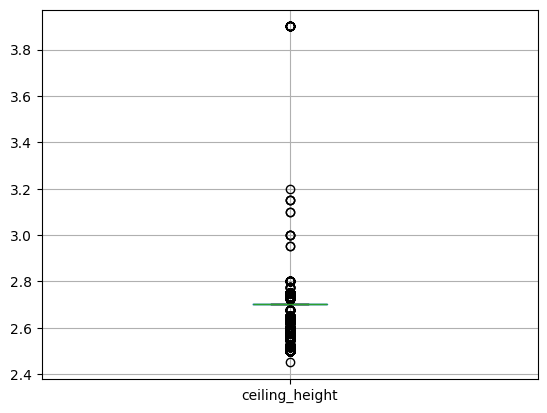

In [84]:
data_ceiling_filter.boxplot(column='ceiling_height')

Несколько выбросов все же есть, но они уже поппадают в более менее реальную картину

##### Общее количество этажей

<Axes: >

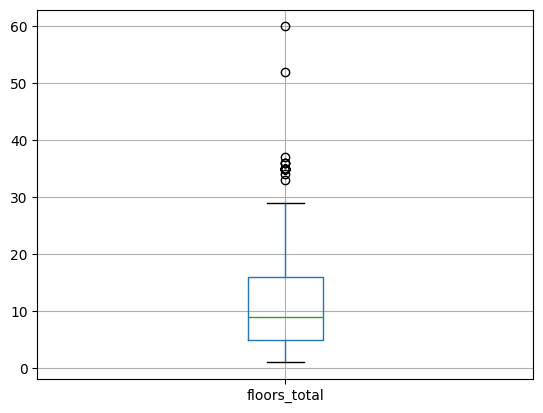

In [85]:
data.boxplot(column='floors_total')

In [86]:
data['floors_total'].describe()

count    23565.000000
mean        10.675875
std          6.594823
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

В этои регионе России самый высокий жилой до имеет 37 этажей. Все что выше выбросы. Нижних выбросов не наблюдается. 

In [87]:
data.query('floors_total > 37')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,current_floor,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around,parks_nearest,ponds_around,ponds_nearest,days_exposition
2253,12,3800000.0,45.5,2018-06-28,2,2.55,60.0,27.4,4,False,False,7.4,0.0,кронштадт,67763.0,49488.0,2.0,342.0,3.0,614.0,166.0
16731,9,3978000.0,40.0,2018-09-24,1,2.70,52.0,10.5,18,False,False,14.0,0.0,санкт-петербург,20728.0,12978.0,1.0,793.0,0.0,NaN,45.0


Первую запись можно сохранить поделив количество на 10 (ошибка в установке запятой). Вторую исключим из финальной выборки поэтажности

In [88]:
data.loc[data['floors_total'] == 60, 'floors_total'] = \
data.loc[data['floors_total'] == 60, 'floors_total']*0.1

In [89]:
data_floors_total_filter = data.query('floors_total < 37')

<Axes: >

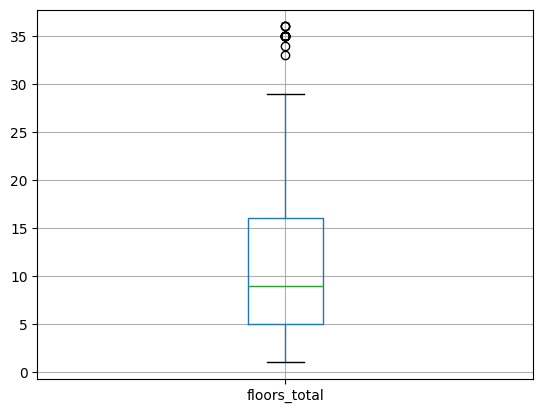

In [90]:
data_floors_total_filter.boxplot(column='floors_total')

Проверим данные в столбце со значением текущего этажа на адекватность. Эти значения не могут быть больше чем общее количество этажей

In [91]:
data_floors_total_filter.query('floors_total < current_floor')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,current_floor,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around,parks_nearest,ponds_around,ponds_nearest,days_exposition


Наблюдаем интересную закономерность - все "неадекватные" значения общей этажности дробные и совпадают со значениями высоты потолков. Не иначе как перекочевали они туда по ошибке во время выгрузки или заполнения. Реальные данные об этажности получить не получится, поэтому заполним значения этого столбца с текущим значением этажа. 

In [92]:
data_floors_total_filter.loc[data_floors_total_filter['floors_total'] < data_floors_total_filter['current_floor'], 'floors_total'] = \
data_floors_total_filter[data_floors_total_filter['floors_total'] < data_floors_total_filter['current_floor']]['current_floor']

In [93]:
data_floors_total_filter['current_floor'].describe()

count    23563.000000
mean         5.877647
std          4.871049
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: current_floor, dtype: float64

<Axes: >

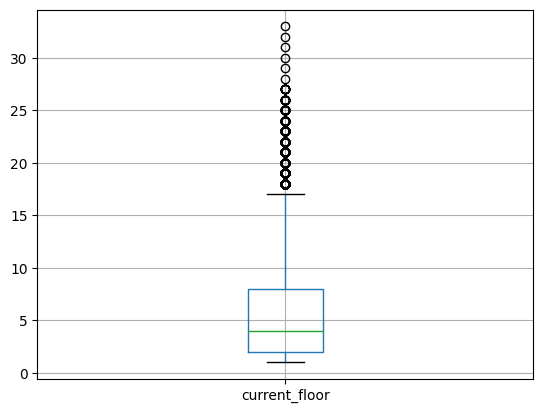

In [94]:
data_floors_total_filter.boxplot(column='current_floor')

В итоге получаем меньшее количество выбросов. Та часть данных, которая не попала в "Ящик с усами" - редки значения достаточно высоких квартир. 

Изучим распределение значений kitchen_area:

<Axes: >

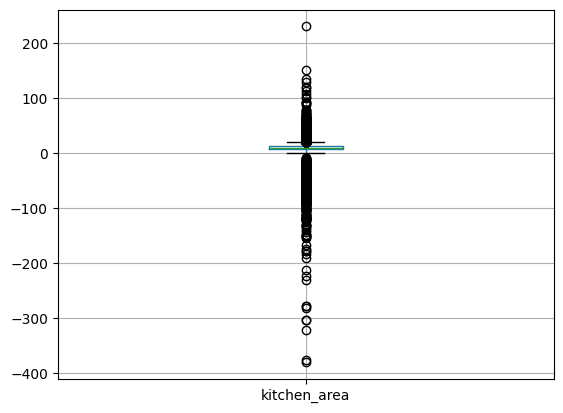

In [95]:
data.boxplot(column='kitchen_area')

Очевидный выброс на максимуме:

In [96]:
data.query('kitchen_area > 200')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,current_floor,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around,parks_nearest,ponds_around,ponds_nearest,days_exposition
7674,20,131000000.0,380.0,2016-09-23,5,2.7,6.0,150.0,4,False,False,230.0,1.0,санкт-петербург,25801.0,4504.0,2.0,161.0,1.0,635.0,901.0


Такая запись выглядит валидно - высокая цена, большач площадь. Очевидно, что такой выброс может быть учтен без удаления. Посмотрим что с парками:

<Axes: >

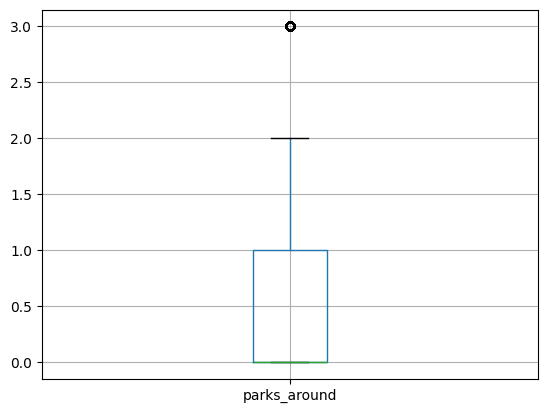

In [97]:
data.boxplot(column='parks_around')

Есть два очевидных выброса - больше 10ти парков рядом - редкость. 

In [98]:
data.query('parks_around > 5')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,current_floor,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around,parks_nearest,ponds_around,ponds_nearest,days_exposition


Очевидно, что, по ошибке, продублировались значения расстояния до ближайшего парка. Роставим в этих записях значения "1", т.к. на наличие хотя бы одного парка, указывает расстояние менее 300 метров до ближайшего. 

In [99]:
data.loc[data['parks_around'] > 5, 'parks_around'] = 1

<Axes: >

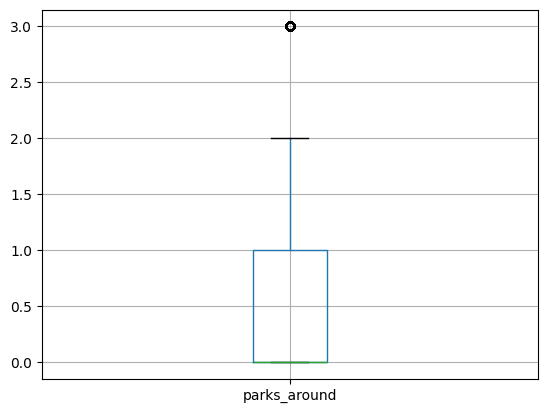

In [100]:
data.boxplot(column='parks_around')

Получили более адекватную картину распределения. Посмотрим еще на общую площадь:

<Axes: >

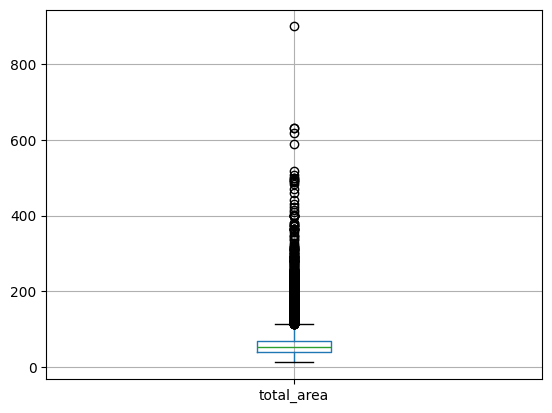

In [101]:
data.boxplot(column='total_area')

Есть очевидные выбросы в районе 600м и 900м2. посмотрим подробнее на эти записи:

In [102]:
data.query('total_area > 550')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,current_floor,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around,parks_nearest,ponds_around,ponds_nearest,days_exposition
3117,19,140000000.0,631.0,2019-03-30,7,2.7,5.0,555.614064,5,False,False,60.0,0.0,санкт-петербург,25707.0,4972.0,0.0,NaN,2.0,210.0,NaN
5358,20,65000000.0,590.0,2019-02-14,15,2.7,6.0,409.000000,3,False,False,100.0,0.0,санкт-петербург,24447.0,4666.0,1.0,767.0,0.0,NaN,14.0
12859,20,140000000.0,631.2,2019-04-09,7,2.7,4.0,322.300000,4,False,False,19.5,1.0,санкт-петербург,25707.0,4972.0,0.0,NaN,2.0,210.0,NaN
15651,20,300000000.0,618.0,2017-12-18,7,2.7,7.0,258.000000,5,False,False,70.0,0.0,санкт-петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,111.0
19540,8,420000000.0,900.0,2017-12-06,12,2.7,25.0,409.700000,25,False,False,112.0,0.0,санкт-петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106.0


Выборка в целом адекватная, за исключением id 3117, где, очевидно, в значения высоты потолков, площади балкона и жилой площади попали одинаковые значения. Вероятно, что общая площадь вполне может принимать такие высокие значения, к тому же это вполне кореллирует с ценой. Посмотрим теперь и на жилую площадь:

<Axes: >

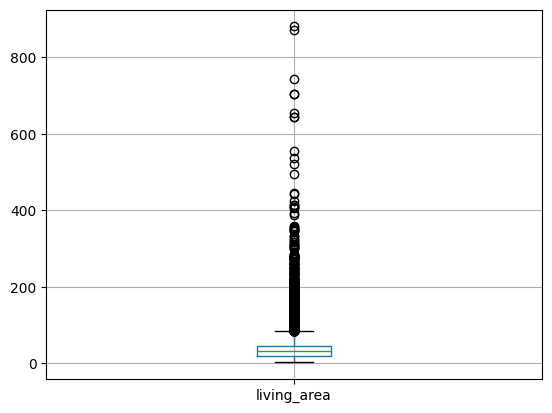

In [103]:
data.boxplot(column='living_area')

In [104]:
data.query('living_area > 350')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,current_floor,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around,parks_nearest,ponds_around,ponds_nearest,days_exposition
581,20,65000000.0,365.00,2019-03-18,7,2.70,7.0,643.389831,7,False,False,-278.389831,0.0,санкт-петербург,19827.0,1690.0,3.0,378.0,3.0,58.0,NaN
1388,20,59800000.0,399.00,2015-01-21,5,2.70,6.0,703.322034,6,False,False,-304.322034,0.0,санкт-петербург,26204.0,6934.0,2.0,149.0,2.0,577.0,719.0
2127,14,32500000.0,234.00,2016-05-26,5,2.70,7.0,412.474576,6,False,False,-178.474576,0.0,санкт-петербург,23987.0,4554.0,1.0,320.0,0.0,NaN,180.0
2243,9,130278280.0,304.00,2015-07-24,5,2.70,9.0,535.864407,7,False,False,-231.864407,0.0,санкт-петербург,25593.0,5913.0,2.0,164.0,0.0,NaN,599.0
2462,18,7900000.0,201.50,2018-08-17,7,2.64,2.0,355.186441,2,False,False,-153.686441,0.0,поселок парголово,54990.0,20665.0,0.0,NaN,0.0,NaN,35.0
3117,19,140000000.0,631.00,2019-03-30,7,2.70,5.0,555.614064,5,False,False,60.000000,0.0,санкт-петербург,25707.0,4972.0,0.0,NaN,2.0,210.0,NaN
3676,12,28789000.0,441.98,2019-01-23,4,2.70,6.0,391.544064,6,False,False,35.050000,0.0,санкт-петербург,20552.0,5181.0,0.0,NaN,0.0,NaN,NaN
5358,20,65000000.0,590.00,2019-02-14,15,2.70,6.0,409.000000,3,False,False,100.000000,0.0,санкт-петербург,24447.0,4666.0,1.0,767.0,0.0,NaN,14.0
5517,20,23000000.0,204.00,2017-11-07,6,2.70,2.0,359.593220,2,False,False,-155.593220,0.0,санкт-петербург,26187.0,5035.0,0.0,NaN,1.0,178.0,299.0
5873,0,38000000.0,400.00,2019-03-15,7,2.70,3.0,705.084746,1,False,False,-305.084746,0.0,санкт-петербург,24889.0,5457.0,1.0,271.0,0.0,NaN,NaN


Два выдающихся значения. Ничего невероятного - просо большие квартиры за внушительные деньги

В итоге мы получили более корректный датасет в составе data, а также репрезентативные выборки для анализа, полученные методом срезов основного датасета:
data_ceiling_filter - выборка без выбросов по высоте потолков
data_floors_total_filter - выборка без выбросов по общему количеству этажей

### Посчитайте и добавьте в таблицу новые столбцы

#### Цена одного квадратного метра

In [105]:
data['metr_cost'] = data['last_price'] / data['total_area']

#### День недели, месяц и год публикации объявления

In [106]:
data['exposition_weekday'] = data['first_day_exposition'].dt.weekday
data['exposition_month'] = data['first_day_exposition'].dt.month
data['exposition_year'] = data['first_day_exposition'].dt.year

#### Тип этажа квартиры (значения — «‎первый», «последний», «другой»)


In [107]:
def floor_group(row):
    """
    Возвращает группу высоты этажа, используя правила:
    - 'первый', если floor равен 1;
    - 'последний', если floor равен общему числу этажей здания (up_floor);
    - 'другой' — во всех остальных случаях.
    """
    
    floor = row['current_floor']
    up_floor = row['floors_total']
    
    if floor == 1:
        return 'первый'
    if floor == up_floor:
        return 'последний'
    return 'другой' 

data['floor_group'] = data.apply(floor_group, axis=1)

#### Расстояние до центра города в километрах

In [108]:
data['city_centers_nearest_km'] = round(data['city_centers_nearest']/1000, 0)

### Проведите исследовательский анализ данных

#### Общая площадь

<Axes: >

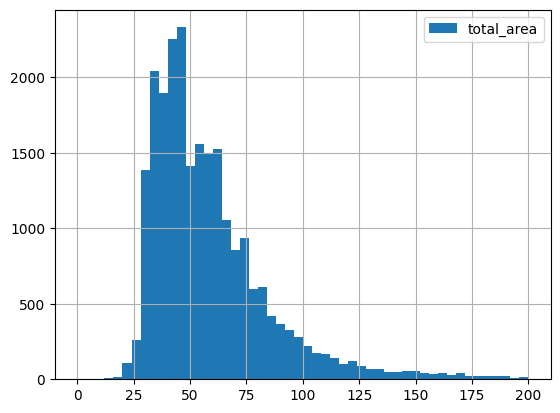

In [109]:
data['total_area'].hist(range = (0, 200), bins=50, legend=True) 
       

In [110]:
data['total_area'].describe()

count    23650.000000
mean        60.329069
std         35.661808
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

Видим распределение близкое к нормальному. Есть пик в области 50м2 - таких значений больше всего. Основные элементы выборки распределены в промежутке значений площади от 30 до 75 м2

##### Жилая площадь

<Axes: >

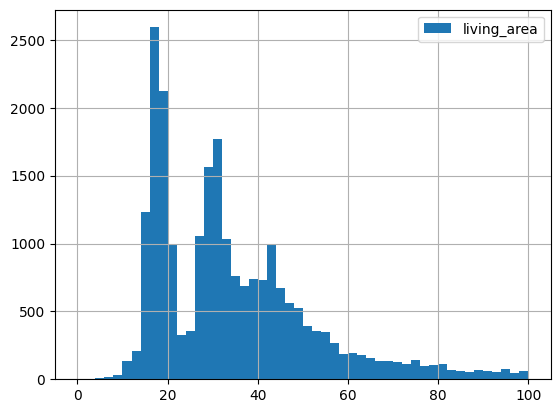

In [111]:
data['living_area'].hist(range = (0, 100), bins=50, legend=True) 

Видим сильные скопления данных около 16-18 м2 и 30м2 - таких значений больше всего, такое может быть. Однако, интересен еще и пик чуть выше нуля - изуче подробнее

<Axes: >

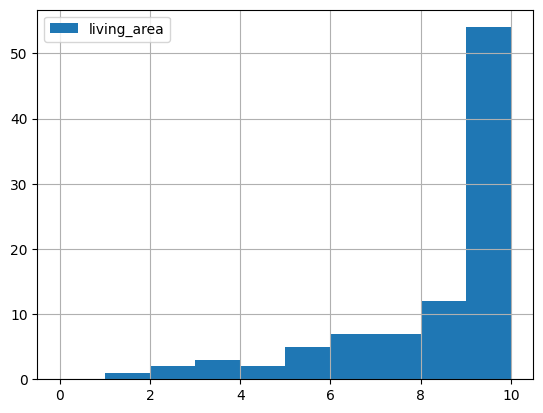

In [112]:
data['living_area'].hist(range = (0, 10), bins=10, legend=True) 

Более 800та значений около 2 м2 - Это странно. Посмотрим на данные:

In [113]:
data.query('living_area < 4')['living_area'].count()

6

Для анализа такие данные не годятся, т.к. значения площади явно некорректные. Сделаем отдельный фильтр для работы с жилой площадью без этих выбросов:

In [114]:
living_area_filter = data.query('living_area < 4')

#### Площадь кухни

<Axes: >

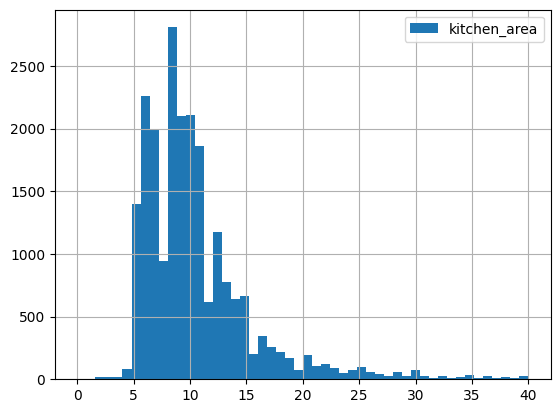

In [115]:
data['kitchen_area'].hist(range = (0, 40), bins=50, legend=True) 

Есть отдельные пики, но в целом картина нормальная, за исключением данных, где площадь меньше 5 м2. Исключим из итогового фильтра:

In [116]:
kitchen_area_filter = data.query('kitchen_area < 5')

#### Цена объекта

In [117]:
data['last_price'].describe()

count    2.365000e+04
mean     6.541127e+06
std      1.089640e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.799000e+06
max      7.630000e+08
Name: last_price, dtype: float64

<Axes: >

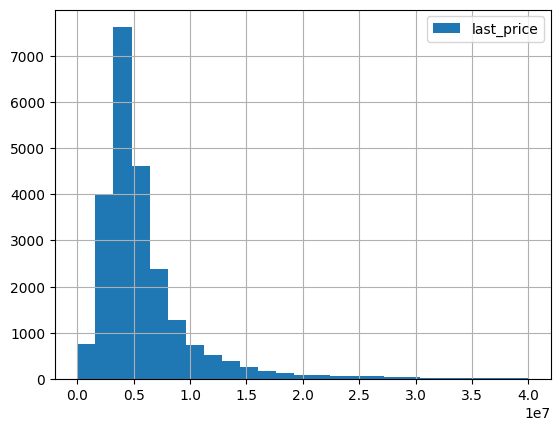

In [118]:
data['last_price'].hist(range = (0, 40000000), bins=25, legend=True) 

Нормальное распределение стоимости c районе 30-40 млн - таких квартир больше всего

#### Количество комнат

In [119]:
data['rooms'].describe()

count    23650.000000
mean         2.070106
std          1.078620
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

<Axes: >

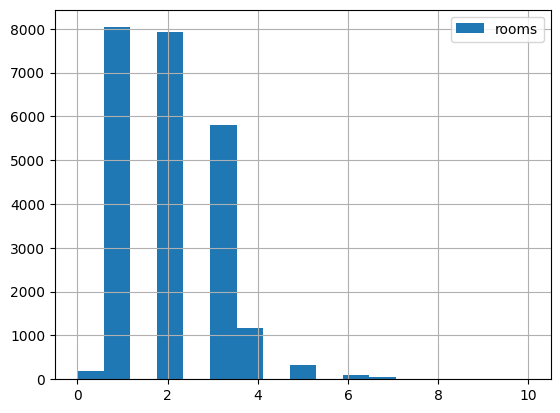

In [120]:
data['rooms'].hist(range = (0, 10), bins=data['rooms'].nunique(), legend=True) 

Собранные данные в основном состоят из квартир с 1, 2, 3 комнатами

#### Высота потолков

<Axes: >

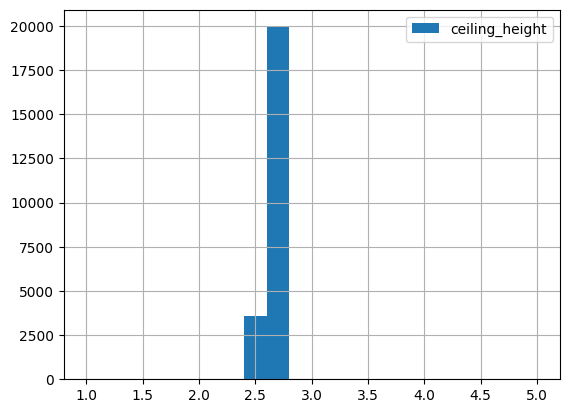

In [121]:
data_ceiling_filter['ceiling_height'].hist(range = (1, 5), bins=20, legend=True) 

Здесь все логично - с этим набором мы уже неплохо поработали на этапе предобработки

#### Этаж квартиры

In [122]:
data['current_floor'].describe()

count    23650.000000
mean         5.893277
std          4.883317
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: current_floor, dtype: float64

<Axes: >

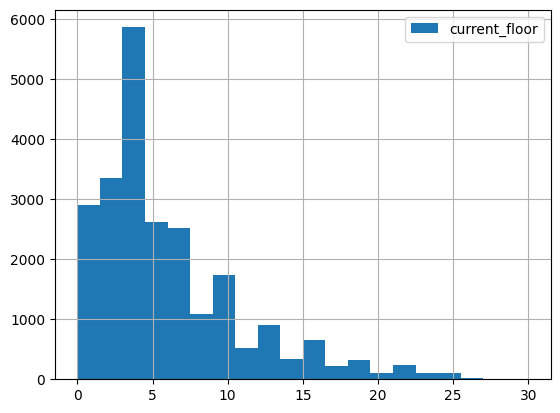

In [123]:
data['current_floor'].hist(range = (0, 30), bins=20, legend=True) 

Этажи 3,4 - самые популярные!

#### Тип этажа квартиры

<Axes: >

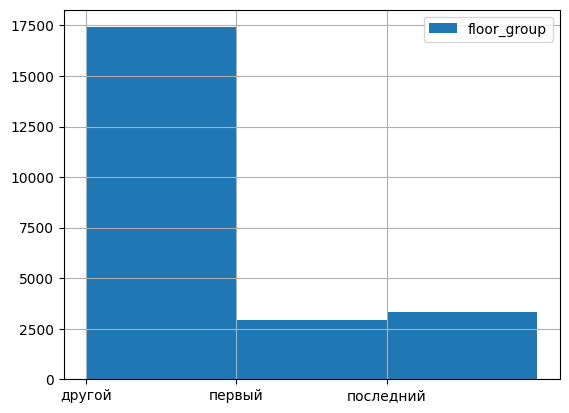

In [124]:
data['floor_group'].hist(range = (0, 3), bins=3, legend=True) 

Как уже выяснилось, полулярнее этажи 3,4. Последние этажи на несколько сотен записей популярнее первых

#### Общее количество этажей в доме

In [125]:
data_floors_total_filter['floors_total'].describe()

count    23563.000000
mean        10.670713
std          6.579601
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         36.000000
Name: floors_total, dtype: float64

<Axes: >

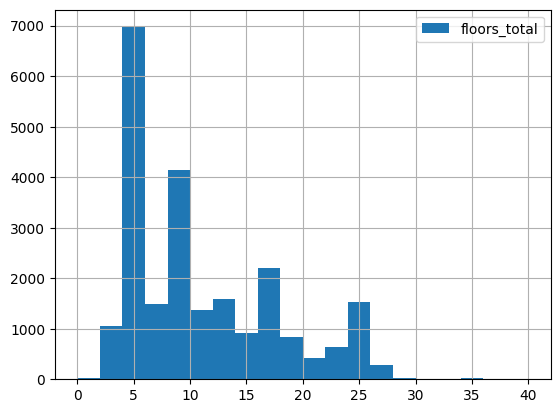

In [126]:
data_floors_total_filter['floors_total'].hist(range = (0, 40), bins=20, legend=True) 

Ожидаемый пик в районе 5ти этажей - это самые популярные пятиэтажки. Также, есть пики в районе 8ми, 16ти и 25ти -этажных построек

#### Расстояние до центра города в метрах

In [127]:
data['city_centers_nearest'].describe()

count    18203.000000
mean     14244.993215
std       8638.121426
min        181.000000
25%       9267.000000
50%      13138.000000
75%      16340.500000
max      65968.000000
Name: city_centers_nearest, dtype: float64

<Axes: >

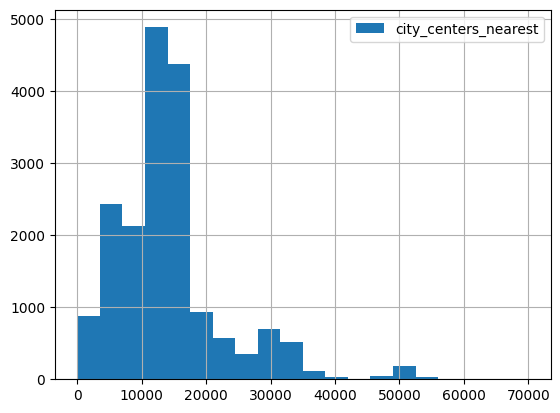

In [128]:
data['city_centers_nearest'].hist(range = (0, 70000), bins=20, legend=True) 

Очевидно, что большее число квартир распределено на расстоянии до 20 000 метров от центра самый большой пик в непосредственной близости и почти в два раза меньше на границе города, но тоже с яыным выдающимся значением в районе 15000 метров от центра, т.к. перед чертой КАД (~16 км от центра)

#### Расстояние до ближайшего аэропорта

<Axes: >

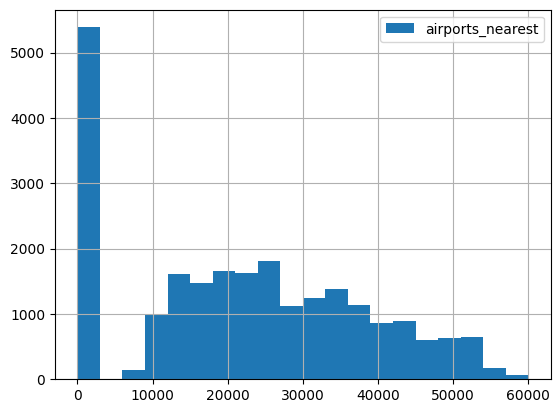

In [129]:
data['airports_nearest'].hist(range = (0, 60000), bins=20, legend=True) 

Весьма хаотичное распределение с пиком около нуля - уберем эти значения из финального фильтра:

In [130]:
airports_nearest_filter = data.query('airports_nearest > 100')

<Axes: >

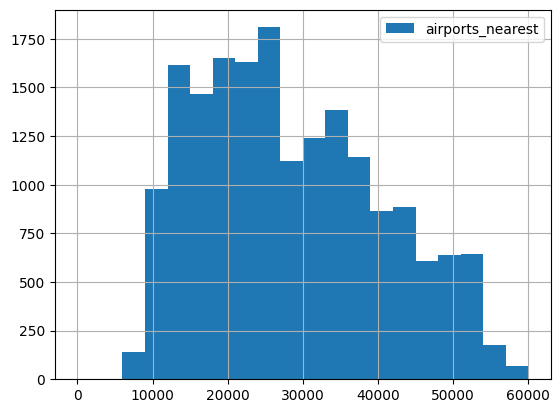

In [131]:
airports_nearest_filter['airports_nearest'].hist(range = (0, 60000), bins=20, legend=True) 

#### Расстояние до ближайшего парка

<Axes: >

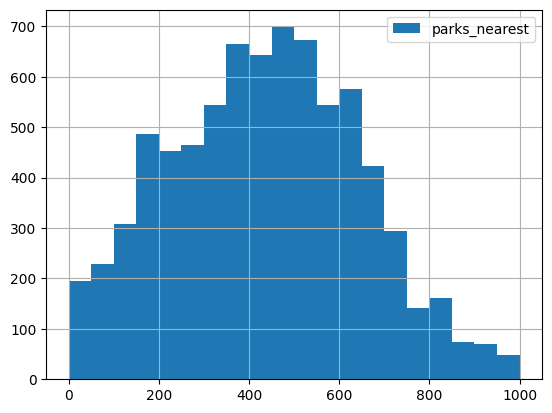

In [132]:
data['parks_nearest'].hist(range = (0, 1000), bins=20, legend=True) 

Есть огромный пик около нуля. Исключим эти данные из выборки:

In [133]:
parks_nearest_filter = data.query('parks_nearest > 10')

<Axes: >

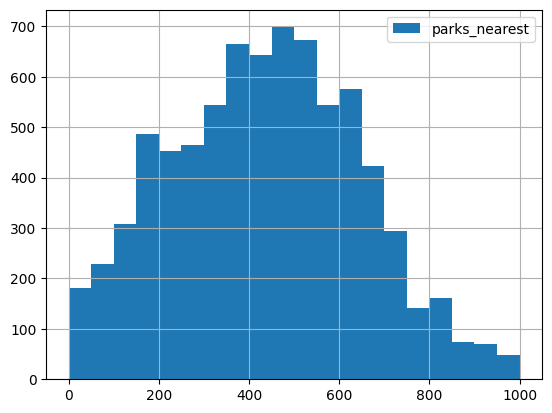

In [134]:
parks_nearest_filter['parks_nearest'].hist(range = (0, 1000), bins=20, legend=True) 

Парки обычно не ближе чем пол километра 

#### День и месяц публикации объявления

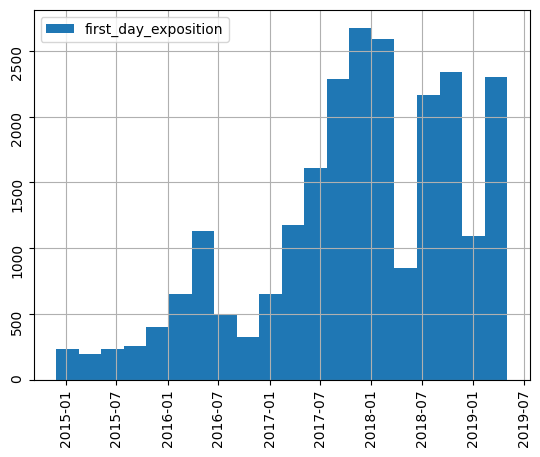

In [136]:
fig, ax = plt.subplots()
data['first_day_exposition'].hist(bins=20, legend=True) 
ax.tick_params(
    labelsize = 10,  
    bottom = True, 
    left = True,   
    labelbottom = True,
    labelleft = True,   
    labelrotation = 90
)    

Большая часть объявлений была опубликована 1.02.2018 (368 объявлений). Самое первое объявление было опубликовано 2014-11-27.11.2014, а последнее 3.5.2019. С течением времени количество объявлений растет. Это можно объяснить темпами развития сервиса. Также, есть явные пики, связанные, очевидно, с сезонностю и поведением рынка недвижимости. 

#### Скорость продажи квартир

<Axes: >

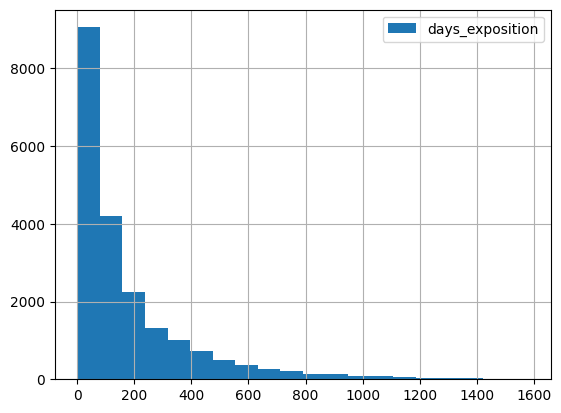

In [137]:
data['days_exposition'].hist(bins=20, legend=True) 


In [138]:
data['days_exposition'].describe()

count    20470.000000
mean       180.753200
std        219.777916
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [139]:
def exposition_group(row):
    """
    Возвращает группу скорости продажи, используя правила:
    - 'быстрая', если days_exposition < 40;
    - 'медленная', если days_exposition > 223;
    - 'другой' — во всех остальных случаях.
    """
    
    days = row['days_exposition']
    
    if days < 40:
        return 'быстрая'
    if days > 223:
        return 'медленная'
    return 'средняя' 

data['exposition_group'] = data.apply(exposition_group, axis=1)

<Axes: xlabel='exposition_group'>

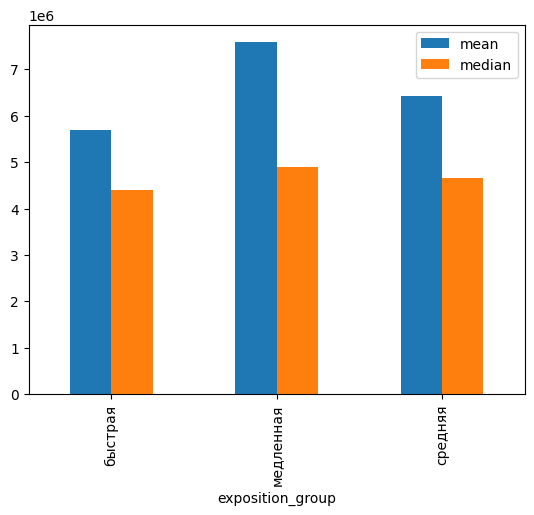

In [140]:
data.pivot_table(index='exposition_group', values='last_price', aggfunc = ('mean', 'median')).plot.bar()

<Axes: xlabel='floor_group', ylabel='exposition_group'>

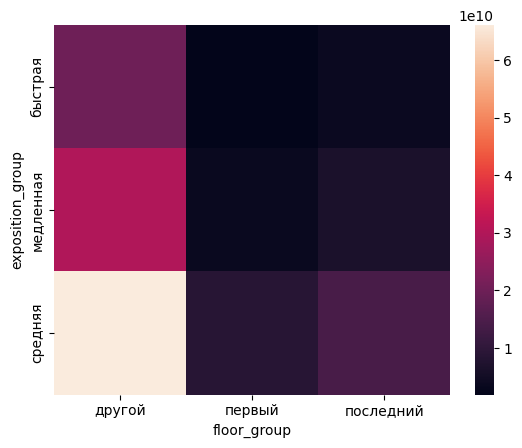

In [141]:
seaborn.heatmap(data.pivot_table(index='exposition_group', columns='floor_group', values='last_price', aggfunc='sum'))

В среднем, продажа квартиры занимает 174 дня - около полугода (90 дней или три месяца по медиане). Продажи можно разделить на группы по скорости, причем разделение оттолкнуться можно от значений квартилей: быстрые продажи - все что меньше первого квартиля (40 дней), а медленные больше третьего (223 дня). В этой выборке большого отличия средней и медианной стоимости продажи в различных группах не наблюдается - медленные продажи при расчете среднего показывают чуть большее значение. Если рассмотреть тепловую диаграму зависимости групп по этажам и скорости продаж, то увидим, что максимальный объем продаж виден на этажах между первым и последним с пиком при средней скорости продажи. Это может говорить о достатояно большом скоплении данных именно на пересечении этих двух групп. Если же мы сравним быстрые, медленные продажи первых и последних этажей то основная выручка сосредотачивается на последних этажах при медленной продаже - "высоко, медленно, дорого"

#### Проанализируем зависимость стоимости квартир от различных факторов

##### Зависимость от общей площади

In [142]:
data['total_area'].corr(data['last_price'])

0.65374289663354

<Axes: xlabel='last_price', ylabel='total_area'>

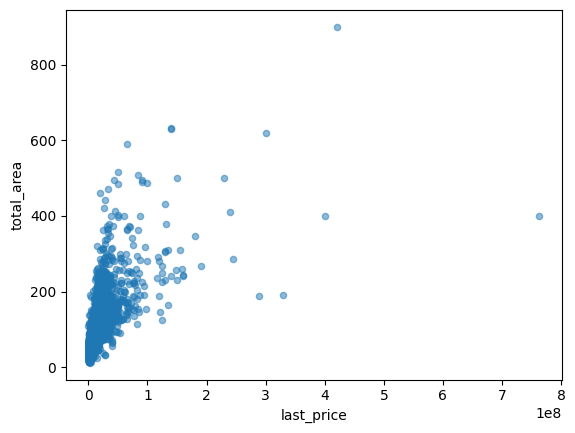

In [143]:
data.plot(x='last_price', y='total_area', kind='scatter', alpha=0.5) 

Коэффециент корреляуии Пирсона указымает на существование зависимости между общей площадбю и стоимости квартикы - 0,65. Действительно, график хависимости имеет не строгую, но, все же, форму, и  показывает что в очновном при росте значения площади, растет и стоимости, что логично и подтверждает прямую зависимость, полученную при поиске корреляции. 

##### Зависимость от жилой площади

In [144]:
data['living_area'].corr(data['last_price'])

0.4611313537749589

<Axes: xlabel='last_price', ylabel='living_area'>

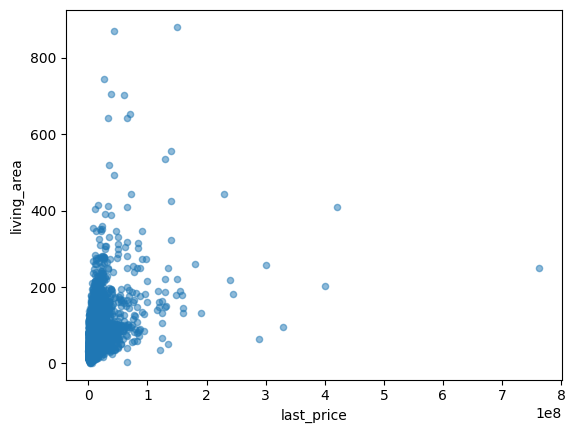

In [145]:
data.plot(x='last_price', y='living_area', kind='scatter', alpha=0.5) 

Здесь видим более слабую зависимость - ниже на 0,1 чем в случае с общей площадью. Объяснить это можно тем, что фактор общего пространства более важен, и, при выборе квартиры, покупатель оперирует, прежде всего, именно этим значением. Однако, такая догадка требует подтверждения. Также, возможно, имеет смысл смотреть на более широкий объем данных или разделять данные по локациям для получения "местных" результатов, ведь, вполне вероятно, что подход к выбору недвижимости будет разниться, например, в регионах и мегополисах. 

##### Зависимость от площади кухни

In [146]:
data['kitchen_area'].corr(data['last_price'])

0.1047616390970343

<Axes: xlabel='last_price', ylabel='kitchen_area'>

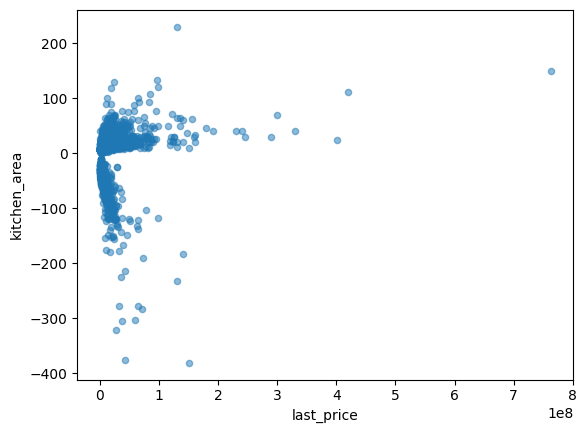

In [147]:
data.plot(x='last_price', y='kitchen_area', kind='scatter', alpha=0.5) 

Еще более низкая зависимость наблюдается при рассмотрении площади кухни. Вероятно, это совсем не является ключевым фактором для формирования цены, либо, зависимость более сложная, и, стандартными методами, не просматривается. 

##### Зависимость от количества комнат

In [148]:
data['rooms'].corr(data['last_price'])

0.36342062218770693

<Axes: xlabel='last_price', ylabel='rooms'>

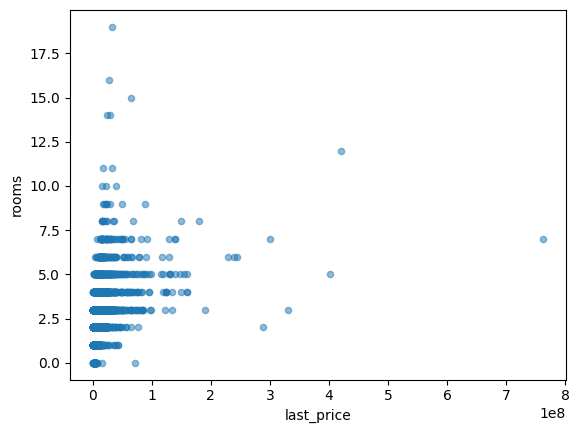

In [149]:
data.plot(x='last_price', y='rooms', kind='scatter', alpha=0.5) 

Зависимость не прослеживается, но, здесь мы имеем дело с категориальными значениями, и, стоит их рассматривать под другим углом:

<Axes: xlabel='rooms'>

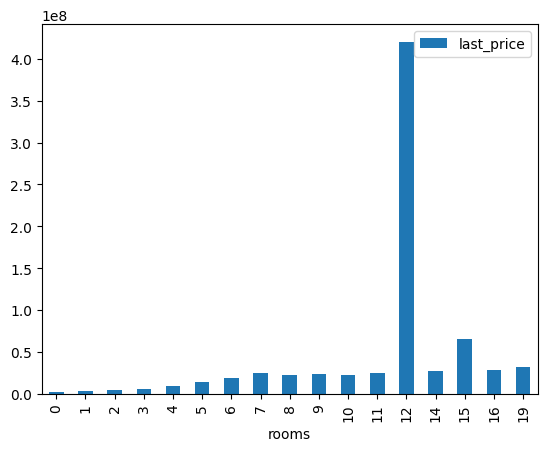

In [150]:
data.pivot_table(index='rooms', values='last_price', aggfunc = 'median').plot.bar()

Такой график позволяет мделать некоторые выводы. Во-первых, есть выброс на 12ти комнатах, который не удолось обноружить при рассмотрении данных по отдельным столбцах. Не беря в расчет это выдающееся еденичное значение медианы, можно сказать, что самые дорогие квартиры, очевидно, имеют большее количество комнат. Так как при работе с корелляцией, зависимости найдено не было, это не главный фактор и, вероятно, большую роль играет именно площадь, а не разбиение ее на помещения. Дополнительно, изучим подробнее значения в этой сводной таблице для понимания природы выброса на 12ти комнатах:

In [151]:
data.pivot_table(index='rooms', values='last_price', aggfunc = 'count')

,last_price
rooms,
0,197
1,8036
2,7924
3,5797
4,1175
5,326
6,105
7,59
8,12


Такой выброс продиктован всего одним значением - стоит убрать его из выорки вместе с данными по 15ти комнатам для анализа количества комнат:

<Axes: xlabel='rooms'>

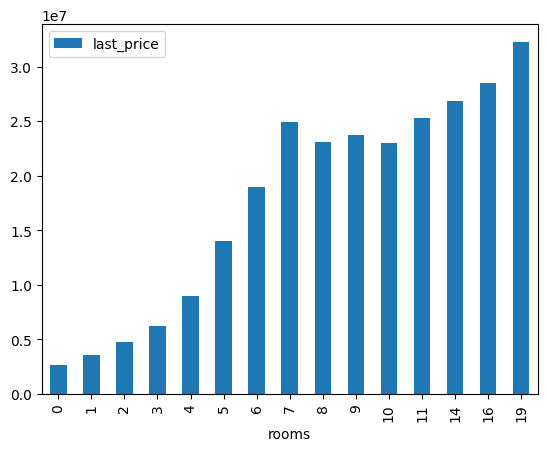

In [152]:
rooms_filter = data.query('rooms != [12, 15]')
rooms_filter.pivot_table(index='rooms', values='last_price', aggfunc = 'median').plot.bar()

Получили более плавную зависимостью. Интересно, что есть резкое увеличение вокруг 7ми-комнатных квартир - вероятно, рынок показывает большой спрос на такие квартиры и позволяет увеличивать стоимость за счет высокого спроса. 

##### Зависимость от этажа

In [153]:
data['current_floor'].corr(data['last_price'])

0.02677043477595818

<Axes: xlabel='last_price', ylabel='current_floor'>

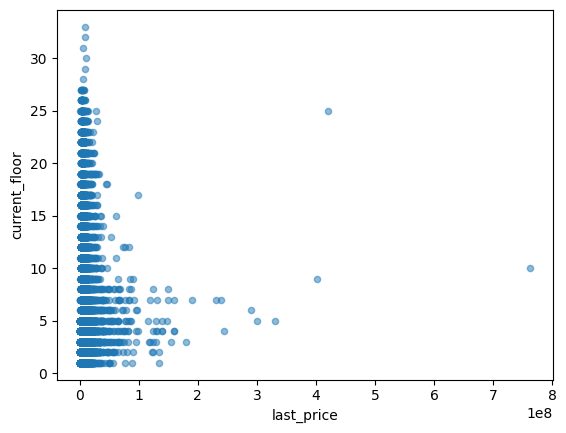

In [154]:
data.plot(x='last_price', y='current_floor', kind='scatter', alpha=0.5) 

Здесь видим совсем слабую связь двух величин. Делаем вывод, что этаж квартиры не является значимым при формировании ценового предложения. 

<Axes: xlabel='current_floor'>

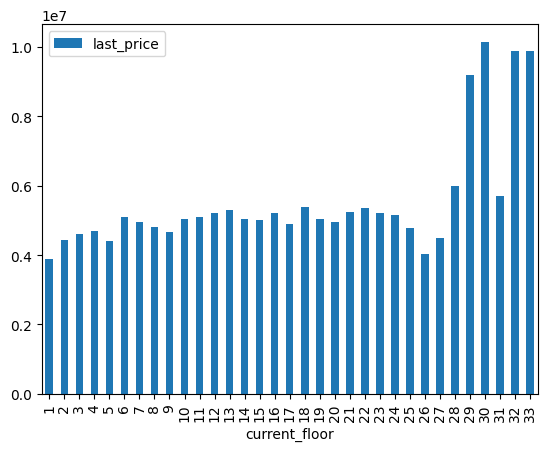

In [155]:
data.pivot_table(index='current_floor', values='last_price', aggfunc = 'median').plot.bar()

Если взглянуть на график распределения медиан цены по значениям этажа, видно, что до 30го этажа картина относительно стабильная, а дальше резкий подъем значений. Видимо, есть в выборке большой блок квартир в элитной недвижимости, находящейся в высотных зданиях. Вывод о зависимости этажа и стоимости сделать сложно. 

##### Зависимость от дня недели публикации объявления

Корреляцию здесь будет считать не корректно. Посмотрим на обычный график распределения суммы продаж:

<Axes: xlabel='exposition_weekday'>

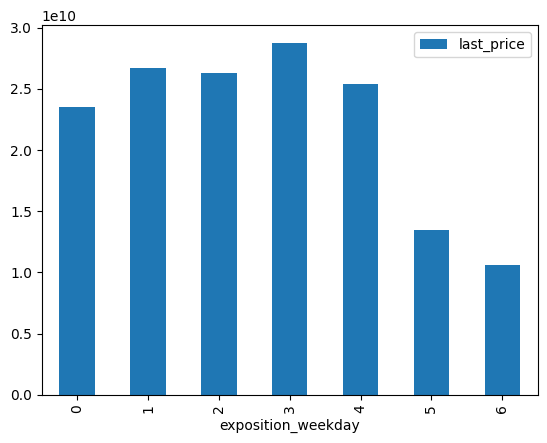

In [156]:
data.pivot_table(index='exposition_weekday', values='last_price', aggfunc = ('sum')).plot.bar()

и количества продаж:

<Axes: xlabel='exposition_weekday'>

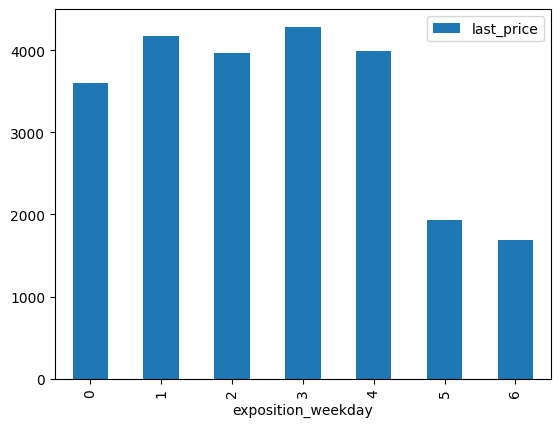

In [157]:
data.pivot_table(index='exposition_weekday', values='last_price', aggfunc = ('count')).plot.bar()

Ключевые моменты: в выходные суммарно было продано квартир на меньшую сумму, причем это не могут быть просто дешевые квартиры, т.к. количество продаж в эти дни, действительно ниже, как мы видим из второго графика. 

##### Зависимость от месяца публикации объявления

Корреляцию здесь будет считать не корректно. Посмотрим на обычный график распределения продаж, их объемма и количества:

<Axes: xlabel='exposition_month'>

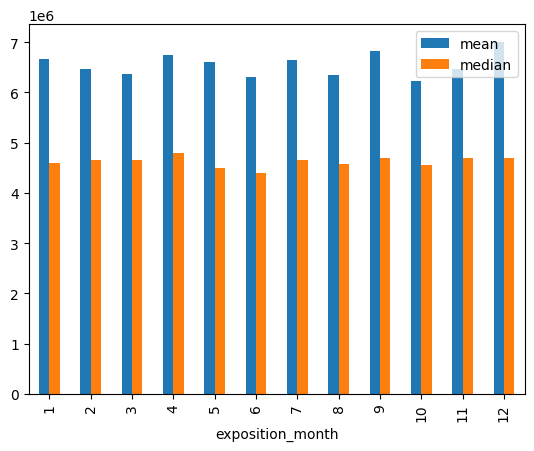

In [158]:
data.pivot_table(index='exposition_month', values='last_price', aggfunc = ('mean', 'median')).plot.bar()

<Axes: xlabel='exposition_month'>

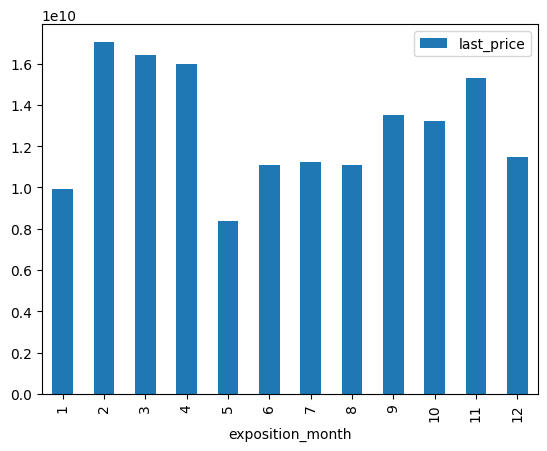

In [159]:
data.pivot_table(index='exposition_month', values='last_price', aggfunc = 'sum').plot.bar()

<Axes: xlabel='exposition_month'>

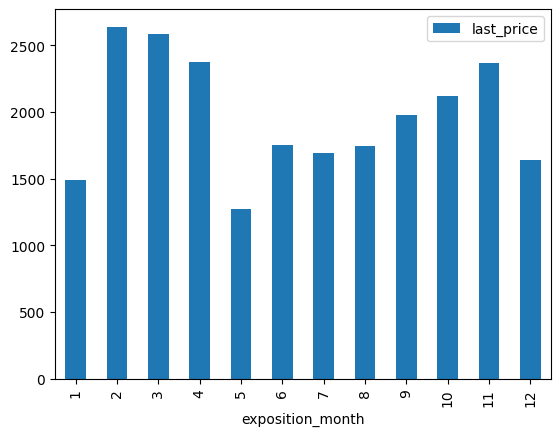

In [160]:
data.pivot_table(index='exposition_month', values='last_price', aggfunc = 'count').plot.bar()

На графике распределения медианы и среднего по месяцам, картину не прояснили. С суммой и количеством продаж интереснее. Максимальные объемы, как по сумме, так и по количеству видим ближе к весне (февраль, март, апрель) и в ноябре. Межсезонье довольно богато на сделки с недвижимостью. 

##### Зависимость от года публикации объявления

<Axes: xlabel='exposition_year'>

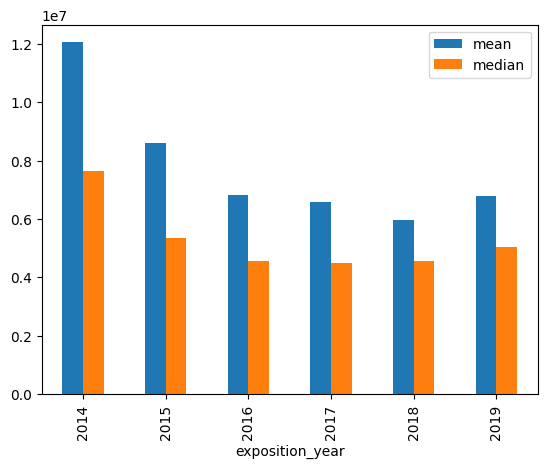

In [161]:
data.pivot_table(index='exposition_year', values='last_price', aggfunc = ('mean', 'median')).plot.bar()

<Axes: xlabel='exposition_year'>

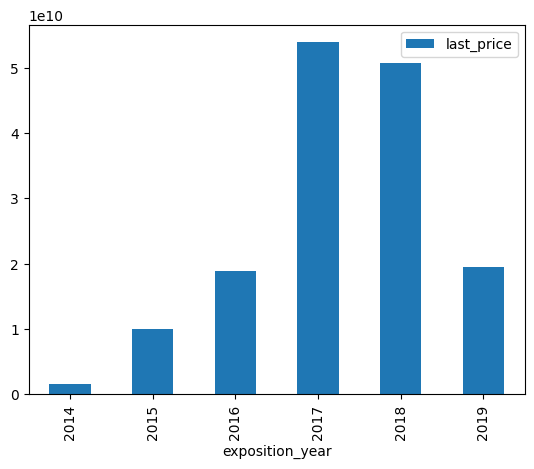

In [162]:
data.pivot_table(index='exposition_year', values='last_price', aggfunc = 'sum').plot.bar()

<Axes: xlabel='exposition_year'>

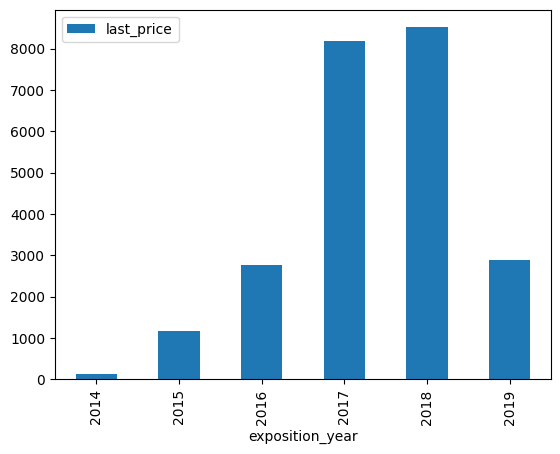

In [163]:
data.pivot_table(index='exposition_year', values='last_price', aggfunc = 'count').plot.bar()

Если посмотреть на графики, то можно видеть явное снижение стоимости проданных квартир начиная с 2015 года. При этом сделок с каждым годом совершалось все больше, росла и выручка, вплоть до 2019 года, когда при низкой стоимости сделок было совершено в два раза меньше чем в 2018 году. Самые богатые на покупки квартир оказались 2017 и 2018 года. 

#### Cредняя цена одного квадратного метра в 10 населённых пунктах

Определим десять населенных пунктов с наибольшим количеством данных:

In [164]:
data.pivot_table(index='locality_name', values='last_price', aggfunc = 'count').sort_values(by='last_price', ascending=False)

,last_price
locality_name,
санкт-петербург,15721
поселок мурино,556
поселок шушары,440
всеволожск,398
пушкин,369
колпино,338
поселок парголово,327
гатчина,307
деревня кудрово,299


Сформируем шорт-лист:

In [165]:
locality_short_list = data.query('locality_name == "гатчина" or\
                                 locality_name == "выборг" or\
                                 locality_name == "парголово" or\
                                 locality_name == "колпино" or\
                                 locality_name == "пушкин" or\
                                 locality_name == "всеволожск" or\
                                 locality_name == "шушары" or\
                                 locality_name == "кудрово" or\
                                 locality_name == "мурино" or\
                                 locality_name == "санкт-петербург"')


Посмотрим среднюю стоимость квадратного метра в этих регионах:

In [166]:
locality_short_list.pivot_table(index='locality_name', values='metr_cost').sort_values(by='metr_cost', ascending=False)

,metr_cost
locality_name,
санкт-петербург,114849.008794
пушкин,103125.819291
кудрово,100253.043304
мурино,92722.708914
колпино,75424.579098
гатчина,68746.146763
всеволожск,68654.473986
выборг,58141.909153


Средняя стоимость квадрдартного метра в Санкт-Петербурге и Выборге разнятся в два раза. 

In [167]:
import matplotlib.pyplot as plt

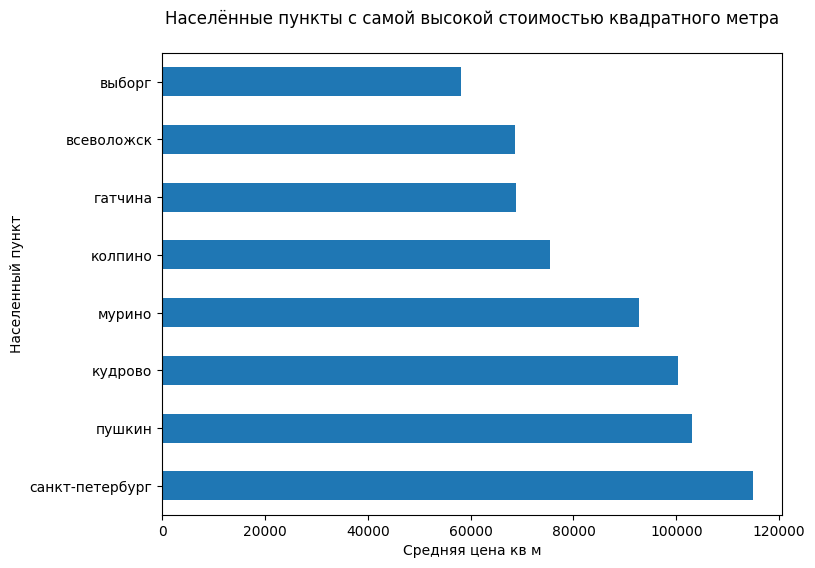

In [168]:
ten_localities = locality_short_list.pivot_table(index='locality_name', values='metr_cost'
                                                ).sort_values(by='metr_cost', ascending=False).reset_index()
ten_localities.plot(x='locality_name', y='metr_cost', 
                                                     kind='barh', figsize=(8,6), legend=False)
plt.xlabel('Средняя цена кв м')
plt.ylabel('Населенный пункт')
plt.title('Населённые пункты с самой высокой стоимостью квадратного метра\n')
plt.show()

#### Cредняя цена одного киллометра до центра Санкт-Петербурга

Для начала, сделаем выборку только по Санкт-Петербургу и определим максимальную удаленность объектов недвижимости от центра:

In [169]:
spb_data = data.query('locality_name == "санкт-петербург"')

In [170]:
spb_data['city_centers_nearest_km'].max()

29.0

Теперь определим среднее значение стоимости квартир, попадающих в те или иные значения удаленности от центра

In [171]:
milepost = list(range(1,30))
milecost = []

for post in milepost:
    mean_km_price = spb_data.query('@post-1 < city_centers_nearest_km <= @post')['last_price'].mean()
    milecost.append(mean_km_price)

data_milecost = pd.DataFrame(data=(milepost), columns=['km'])
data_milecost['cost_for_km'] = milecost


Посмотрим, как эти значения расположились на диаграмме:

<Axes: xlabel='km'>

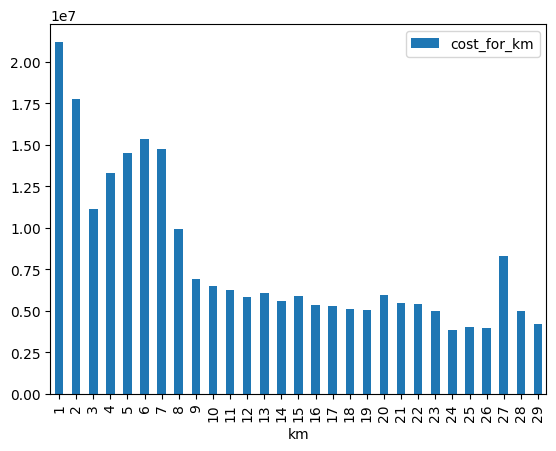

In [172]:
data_milecost.plot.bar(x='km', y='cost_for_km')

In [173]:
data_milecost['km'].corr(data_milecost['cost_for_km'])

-0.7902714355895287

То что в непосредственной близости от центра стоимость резко возростает, не удивительно, но интересно, что на трех километрах есть спад с последующим ростом и новым плавным спадом. Спад на 3 км можно объяснить попадением в выборку старого фонда, конечно, не стоит забывать о влиянии других факторов. Например, в этой части выборки могли просто оказаться квартиры малого метража в юольшом количестве, что сместило среднее здначение. Дальнейший рост, выравнивеает картину с дальнейшим постепенным спадом стоимости по мере удаления от центра. Выводы подтверждаются сильной обратной корелляцией Пирсона (-0,79)

### Общий вывод

В рамках предобработки данных был выявлен большой объем пропусков в ряде значений. Отдельные столбцы содержали до 85% пропусков. После заполнений релевантными значениями, удалением незначащих столбцов количество пропусков существенно сократилось и более не дастигало 50% по отдельным значениям. Наибольшее количество пропусков осталось в значениях, связанных с дальностью и количеством прудов и парков поблизости, а также дате снятия объявления. Объяснить это можно тем, что при остутствии значащих фактов в этих значениях, при заполнении объявлений, данные просто не указывались, а дата снятия объявления не могла быть проставлена в случаях, когда объявление просто не снято. <br/> <br/> 
Также, в рамках предобработки, была проведена работа над исключением не явных дубликатов в названии локаций, переименованы столбцы для сублюдения правил оформления. 

На последующих этапах датасет был дополнен необходимыми значениями для дальнейшего анализа: типы этажности, данные о дне недели, месяце и годе публикации объявления, были выделены из имеющихся данных. Была оценена стоимость одного километра до центра города в среднем по Санкт-Петербургу, а также скорость продажи квартиры в среднем. В итоге, видим, что в среднем, квартиры продаются за 174 дня. Самая дорогая локация, с точки зрения стоимости квадратного метра - Санкт-Петербург(110 000 рублей/м2), на 10м месте Выбор (80 000 рублей/м2). Основную стоимость квартир в Санкт-Петрбурге, формируют варианты, расположенные до 8км от центра города. 

Проанализировав возможность различных зависимостей, можно выделить основные критерии, влияющие на стоимость квартиры - это удаленность от центра, общая площадь. В остальных проанализированных разрезах сильных зависимостей найдено не было. Можно, также отметить полезность разделения на группы по скорости продажи квартир и значению этажа - с помощю тепловой диаграммы хорошо видно, что максимальные объемы выручки выходят из пересечения групп последних этажей и медленных продаж. 